/home/team12/team12/data/gear_images_normalized/axes : 0
/home/team12/team12/data/gear_images_normalized/boots : 1
/home/team12/team12/data/gear_images_normalized/carabiners : 2
/home/team12/team12/data/gear_images_normalized/crampons : 3
/home/team12/team12/data/gear_images_normalized/gloves : 4
/home/team12/team12/data/gear_images_normalized/hardshell_jackets : 5
/home/team12/team12/data/gear_images_normalized/harnesses : 6
/home/team12/team12/data/gear_images_normalized/helmets : 7
/home/team12/team12/data/gear_images_normalized/insulated_jackets : 8
/home/team12/team12/data/gear_images_normalized/pulleys : 9
/home/team12/team12/data/gear_images_normalized/rope : 10
/home/team12/team12/data/gear_images_normalized/tents : 11
(2122, 128, 128, 3)
(2122,)
Split...
(1697, 128, 128, 3)
(1697, 12)
(425, 128, 128, 3)
(425, 12)
Start ...
model step 1
model step 2
model step 3
epoch:0
Cost after epoch 0: 3.166725
epoch:1
Cost after epoch 1: 2.004362
epoch:2
Cost after epoch 2: 1.548947
epoch:

Cost after epoch 184: 0.327205
epoch:185
Cost after epoch 185: 0.316903
epoch:186
Cost after epoch 186: 0.294316
epoch:187
Cost after epoch 187: 0.279125
epoch:188
Cost after epoch 188: 0.284372
epoch:189
Cost after epoch 189: 0.317354
epoch:190
Cost after epoch 190: 0.314625
epoch:191
Cost after epoch 191: 0.305610
epoch:192
Cost after epoch 192: 0.336450
epoch:193
Cost after epoch 193: 0.297109
epoch:194
Cost after epoch 194: 0.346216
epoch:195
Cost after epoch 195: 0.307971
epoch:196
Cost after epoch 196: 0.349032
epoch:197
Cost after epoch 197: 0.303628
epoch:198
Cost after epoch 198: 0.306043
epoch:199
Cost after epoch 199: 0.297627


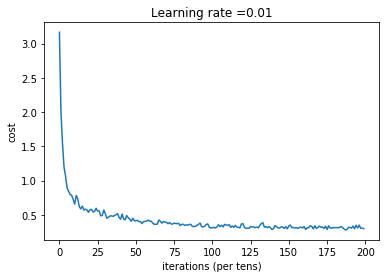

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.8791986
Test Accuracy: 0.8329412
Done


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from PIL import Image, ImageOps
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split

%matplotlib inline
np.random.seed(1)

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape=(None, n_y))

    return X, Y

def initialize_parameters():
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [3, 3, 3, 32], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [3, 3, 32, 64], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W3 = tf.get_variable("W3", [3, 3, 64, 128], initializer=tf.contrib.layers.xavier_initializer(seed=0))

    parameters = {"W1": W1, "W2": W2, "W3": W3}
    return parameters

def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']

    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    Z1 = tf.layers.batch_normalization(Z1)
    # add batch normalization
    #Z1 = tf.nn.bias_add(Z1, tf.Variable(tf.random_normal([Z1.shape.as_list()[0]])))
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    Z2 = tf.layers.batch_normalization(Z2)
    # add batch normalization
    #Z2 = tf.nn.bias_add(Z2, tf.Variable(tf.random_normal([Z2.shape.as_list()[0]])))
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    Z3 = tf.nn.conv2d(P2, W3, strides = [1,1,1,1], padding = 'SAME')
    Z3 = tf.layers.batch_normalization(Z3)
    # add batch normalization
    #Z2 = tf.nn.bias_add(Z2, tf.Variable(tf.random_normal([Z2.shape.as_list()[0]])))
    A3 = tf.nn.relu(Z3)
    P3 = tf.nn.max_pool(A3, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    # add anohter layer

    P4 = tf.nn.dropout(P3, 0.1)
    P  = tf.contrib.layers.flatten(P4)
    Z4 = tf.contrib.layers.fully_connected(P, 12, activation_fn=None)

    return Z4

def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))

    return cost

def model(X_train, Y_train, X_test, Y_test, learning_rate=0.01,
          num_epochs=200, minibatch_size=64, print_cost=True):

    print('model step 1')
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    print('model step 2')
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    print('model step 3')
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            print("epoch:" + str(epoch))
            
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                #print("minibatch:" + str(minibatch))
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})                
                minibatch_cost += temp_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 1 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
            
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters
    

def random_mini_batches(X, Y, mini_batch_size = 128, seed = 0):
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]
    #shuffled_X, shuffled_Y = shuffle(X, Y, random_state=seed)

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

from PIL import Image, ImageOps
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split

#img_root = '/Users/zhigangyao/workspace/openhack/gear_images_normalized'
img_root = '/home/team12/team12/data/gear_images_normalized'
#img_root = '/home/team12/team12/data/gear_images_equalize'
img_dirs = [os.path.join(img_root, o) for o in os.listdir(img_root) if os.path.isdir(os.path.join(img_root,o))]
img_dirs.sort()
x = []
y = []
category = 0
for img_dir in img_dirs:
    print(img_dir + " : " + str(category))
    count = 0
    img_files = [f for f in listdir(img_dir) if isfile(join(img_dir, f))]
    for img_file in img_files:
        #print(img_dir + '/' + img_file)
        image_path = img_dir + '/' + img_file
        x.append(np.array(Image.open(image_path)))
        y.append(category)
        #if count > 100:
        #    break
        count += 1
    category += 1

X = np.array(x)
#Y = tf.one_hot(np.array(y), 12)
Y = np.array(y)
print(X.shape)
print(Y.shape)

print('Split...')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=41)
#Y_train = tf.one_hot(y_train, 12)
#Y_test = tf.one_hot(y_test, 12)
Y_train = convert_to_one_hot(y_train, 12).T
Y_test = convert_to_one_hot(y_test, 12).T
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

print('Start ...')
_, _, parameters = model(X_train, Y_train, X_test, Y_test)
print('Done')

In [ ]:

#img_root = '/Users/zhigangyao/workspace/openhack/gear_images_normalized'
#img_root = '/home/team12/team12/data/gear_images_normalized'
img_root = '/home/team12/team12/data/gear_images_equalize'
img_dirs = [os.path.join(img_root, o) for o in os.listdir(img_root) if os.path.isdir(os.path.join(img_root,o))]
img_dirs.sort()
x = []
y = []
category = 0
for img_dir in img_dirs:
    print(img_dir + " : " + str(category))
    count = 0
    img_files = [f for f in listdir(img_dir) if isfile(join(img_dir, f))]
    for img_file in img_files:
        #print(img_dir + '/' + img_file)
        image_path = img_dir + '/' + img_file
        x.append(np.array(Image.open(image_path)))
        y.append(category)
        #if count > 100:
        #    break
        count += 1
    category += 1

X = np.array(x)
#Y = tf.one_hot(np.array(y), 12)
Y = np.array(y)
print(X.shape)
print(Y.shape)

print('Split...')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=41)
#Y_train = tf.one_hot(y_train, 12)
#Y_test = tf.one_hot(y_test, 12)
Y_train = convert_to_one_hot(y_train, 12).T
Y_test = convert_to_one_hot(y_test, 12).T
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

print('Start ...')
_, _, parameters = model(X_train, Y_train, X_test, Y_test)
print('Done')

In [ ]:

#img_root = '/Users/zhigangyao/workspace/openhack/gear_images_normalized'
img_root = '/home/team12/team12/data/gear_images_normalized'
#img_root = '/home/team12/team12/data/gear_images_equalize'
img_dirs = [os.path.join(img_root, o) for o in os.listdir(img_root) if os.path.isdir(os.path.join(img_root,o))]
img_dirs.sort()
x = []
y = []
category = 0
for img_dir in img_dirs:
    print(img_dir + " : " + str(category))
    count = 0
    img_files = [f for f in listdir(img_dir) if isfile(join(img_dir, f))]
    for img_file in img_files:
        #print(img_dir + '/' + img_file)
        image_path = img_dir + '/' + img_file
        x.append(np.array(Image.open(image_path)))
        y.append(category)
        #if count > 100:
        #    break
        count += 1
    category += 1

X = np.array(x)
#Y = tf.one_hot(np.array(y), 12)
Y = np.array(y)
print(X.shape)
print(Y.shape)

print('Split...')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=41)
#Y_train = tf.one_hot(y_train, 12)
#Y_test = tf.one_hot(y_test, 12)
Y_train = convert_to_one_hot(y_train, 12).T
Y_test = convert_to_one_hot(y_test, 12).T
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

print('Start ...')
_, _, parameters = model(X_train, Y_train, X_test, Y_test)
print('Done')